## Contexts

### 1. READY
    1-1 오늘의 Exp와 Rubric  
    1-2 사용하는 라이브러리  

### 2. GAME
    2-1. 데이터 읽어오기  
    2-2. 데이터 전처리  
        -1. Normalization
        -2. Minibatch
        
    2-3. 모델 학습  
        -1. Generator 구현
        -2. Discriminator 구현
        -3. loss, Accuracy, Optimaizer 구현
        
    2-4. 데이터 평가   
        -1. 훈련과정 시각화
        -2. 최종 결과
        -3. Try#1
        -4. Try#2
        -5. Try#3
        -6. Final Try

### 3. POTG (best Play Of The Game
    3-1. 소감(POTG)  
    3-2. 어려웠던 점과 극복방안  
    3-3. 추후  

---


# 1. Ready
## 1-1. 오늘의 Exp와 Rubric


오늘은 GAN 이라는 Ganerative Adverserial Network 모델을 이용한다.

기본의 모델은 보통 class 가 정해져 있고, test 데이터 셋의 class 를 판별해 맞추는  
`판별 모델링` 이다.

하지만 거기서 더 진보해, 우리가 원하는 test 데이터를 생성해 낼 수 있는
`생성 모델링` 을 구현하는 것이 GNN 이다.

기본적인 원리는 다음과 같다.

1. 새로운 데이터를 생성해내는 Generator 모델을 만든다.

2. 새로운 데이터가 우리가 원하는 데이터에 가까운지 판별하는 Discriminator 모델을 만든다.

3. 우리가 원하는 데이터와 다른 정도를 측정해, 파라미터 값을 변환해주고, 이를 반복한다.

---
GAN 모델링을 통해 CIFAR-10 내부 데이터를 생성해 보는 작업을 한다!!

[CIFAR-10 Image](https://www.cs.toronto.edu/~kriz/cifar.html)

cifar-10 이란 다양한 data engineer 들이 우리같은 학습자를 위해 마련해 준 이미지 데이터 집합이다.  

60000장의 사진으로 되어 있으며, 10 종류의 사진이 각 6000장씩 있다.  

<비행기, 자동차, 새, 고양이, 사슴, 개, 개구리, 말, 배, 트럭>

우리가 이 데이터를 통해 Generator 를 학습시켜  
육안으로 해당 클래스 중 하나로 선별할 수 있을만큼 그럴듯한 사진을 만들면  
성공이다.

목표로 할 Rubric 은 다음과 같다.

|평가문항|상세기준|
|---|---|
|1. GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.|오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.|
|2. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.|gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.|
|3. 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.|제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였다.|

## 1-2. 사용하는 라이브러리

In [34]:
import os
import glob #데이터 경로 설정 라이브러리

import time #시간을 나타내주는 라이브러리

import PIL
import imageio #데이터 시각화 라이브러리

import numpy as np #배열 데이터 관리 라이브러리

import tensorflow as tf
from tensorflow.keras import layers
from IPython import display #모델 생성 라이브러리

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import seaborn as sns #데이터 시각화 라이브러리

print("tensorflow", tf.__version__)

tensorflow 2.6.0


In [2]:
import random
import os

os.environ["PYTHONHASHSEED"] = "1234"
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

np.random.seed(123)
random.seed(123)
tf.random.set_seed(1234)

과제를 시작하기에 앞서, 다양한 모델을 돌리며 성능의 성장을 기록하기 위해서  
난수 생성에 seed 값을 정해 두었다.

모델 생성 시 랜덤으로 들어가는 가중치 초기화 값 등  
불분명한 수치가 항상 같은 값으로 정해진다는 뜻이다.

학습 시 선언될 수 있는
numpy 랜덤 값,  
tensor flow 랜덤 값을 고정해주었다.

# 2. GAME
## 2-1. 데이터 읽어오기

tensor flow 에서 cifar-10 에 대한 데이터를  
지원해주고 있다. 

In [3]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [4]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


## 2-2.데이터 전처리

### 2-2-1. Normalization  

우선 0부터 255까지인 RGB 값을 -1 과 1 사이로 줄여주어 정규화한다.

In [5]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


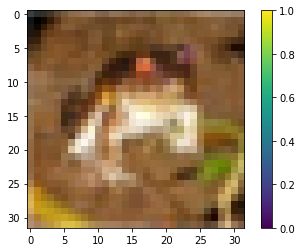

In [6]:
plt.imshow((train_x[0].reshape(32, 32, 3) +1) / 2.0)
plt.colorbar()
plt.show()



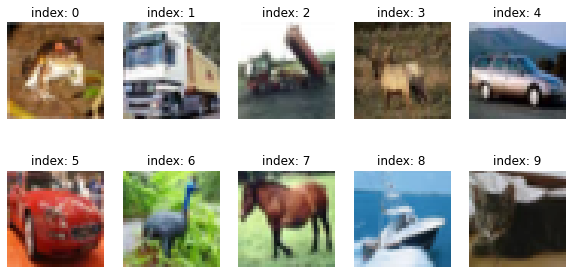

In [7]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow((train_x[i].reshape(32, 32, 3) +1) / 2.0) 
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

### 2-2-2. Minibatch

데이터를 적절히 학습시키기 위해 순서를 배치사이즈 별로 섞어준다.

In [48]:
BUFFER_SIZE = 50000 #데이터의 수
BATCH_SIZE = 512

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE) #미니배치 데이터셋 구성

## 2-3.모델 학습

### 2-3-1. Generator 구현

In [10]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [11]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

(32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현했다.

생성자 모델은 Discriminator 가 판별할 가짜 이미지를 만들어낸다.  
그래서 랜덤으로 벡터값이 들어오면 데이터를 확장시켜 가짜 이미지를 만든다.  

한번 랜덤 노이즈 데이터르 줘서 방금 구현한 생성자로 랜덤이미지를 생성해 본다.

In [12]:
noise = tf.random.normal([1, 100])

In [13]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

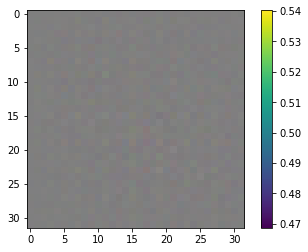

In [14]:
plt.imshow((generated_image[0]+1)/2 )
plt.colorbar()
plt.show()

아직은 아무런 학습을 하지 못해 아무런 이미지를 생성하지 못한다.  
추후에 어떤 식으로 학습할지 기대해보자.

### 2-3-2. Discriminator 구현

판별자(Discriminator) 모델은  
진짜 이미지들과 Generator가 만든 가짜 이미지를 구분하는 모델이다.

때문의 기존까지의 모델처럼 Convolution layer로 이미지의 특징을 뽑아 판단한다.

In [15]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [16]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

위에서 생성한 랜덤 noise 데이터를 한번 판별자 모델에 넣어 보았다.

### 2-3-3. Loss, Optimizer 구현

두 모델은 엄연히 각각의 모델이기때문에 

Loss 함수와 Optimizer 를 각각 구성해줄 수 있다.

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### Generator

Generator 는 Discriminator의 손실함수가 크도록 만드는 것이 목표이다.  
자신의 사진이 진짜인 것처럼 속여야 하기 때문이다.

loss 함수로는 cross entrophy 를 사용했다

In [18]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

opt 함수로는 Adam 을 쓰되, GAN 모델에 맞도록 파라미터를 변경해 주었다.

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(epsilon=1e-4,learning_rate=0.0002,beta_1=0.5 )


#### Discriminator


Discriminator 는 가짜 사진을 잘 분별해냄과 동시에,  
진짜 사진은 진짜라고 말할 줄도 알아야 한다.  
때문에 loss 값과 함께 accuracy 함수도 설정해 주었다.

역시 항상 지켜내는 쪽이 더 고생이다.



loss 함수는 진짜 이미지 분별 cross entropy 와 가짜 이미지 분별 cross entrophy 를  
더해 주었다.

In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

accuracy 코드에 대한 설명을 하면  

`greater_equal(output, tf.constant[0.5])`  
각 원소가 0.5 이상인지 아닌지 True False 로 반환  

`cast( output, ft.float32)`  
True 면 1.0, False 면 으로 변환  

`mean()`  
내부의 결과를 평균으로 변환

결과적으로 사진을 잘 분별한 정도를 나타낸다.

In [21]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

opt 함수로는 SGD 기법을 사용했다.

In [22]:
discriminator_optimizer = tf.keras.optimizers.SGD()

---

## 2-4.데이터 평가
### 2-4-1. 훈련과정 시각화

항상 같은 샘플값을 넣어 생성자가 같은 데이터를 가지고  
얼마나 더 잘 만드는지를 시각적으로 확인할 수 있게 만들어보도록 하겠다.

In [23]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [24]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

데코레이터 `@ft.function` 을 통해 사용할 값이 바로  
tf 타입의 속성으로 바뀌도록 선정해 주었다.

한번의 학습이 끝난 뒤, 아까 만든  
noise 데이터로 생성자의 작품을 구경할 수 있다.

In [37]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] +1) /2.0)
        plt.axis('off')
   
    plt.savefig('{}/aiffel/workplace/E10/dcgan_newimage/cifar/generated_samples2/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

또한  
1. 생성자 손실 
2. Dis 손실
3. real Image 판별 정확도
4. fake Image 판별 정확도 

네 값을 각각 비교할 수 있도록 그래프를 만들었다.

In [26]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/workplace/E10/dcgan_newimage/cifar/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

더 정확한 비교를 위해 그래프에 추세선을 그리는 `regplot` 메서드 코드를 이용했다.

In [43]:
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211) 
    sns.regplot(
        x=[x for x in range(len(history["gen_loss"]))], 
        y=np.array(history["gen_loss"]),
        line_kws={"color" : "black"})
    
    sns.regplot(
        x=[x for x in range(len(history["disc_loss"]))], 
        y=np.array(history["disc_loss"]),
        line_kws={"color" : "black"})
     
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    
    sns.regplot(
        x=[x for x in range(len(history["fake_accuracy"]))], 
        y=np.array(history["fake_accuracy"]),
        line_kws={"color" : "black"})
    
    sns.regplot(
        x=[x for x in range(len(history["real_accuracy"]))], 
        y=np.array(history["real_accuracy"]),
        line_kws={"color" : "black"})

    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/workplace/E10/dcgan_newimage/cifar/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

모델 epoch 을 많이 돌릴 예정이기에,
중간마다 관련 가중치와 모델의 학습 정도를 저장 할 수 있도록 체크포인트 메서드  
`Checkpoint` 를 사용했다.

In [44]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/workplace/E10/dcgan_newimage/cifar/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

그리고 이걸 다 합쳐서 epoch 만큼 하시는 코드가 다음과 같다

In [45]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

---

### 2-4-2. 최종 결과

다음의 그래프가 최종 결과이다.

In [55]:
save_every=5
EPOCHS = 200

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)


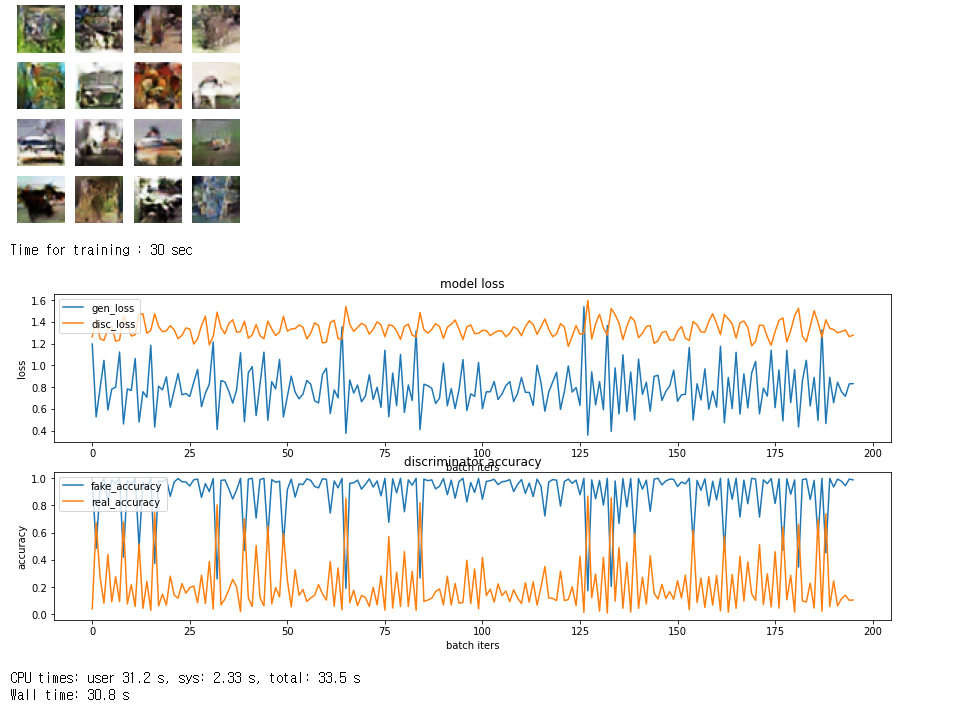

---

최종 결과값으로 나온 사진을 보면 충분히 사진의 클래스를 유추할 수 있다 💨  

진짜 내가 억지부리는게 아니라  
1번, 5번, 13번은 개구리를 나타내려 했다  
6번은 검정색 자동차 앞부분이 보인다.  
9번, 11번은 커다란 유람선이 보인다.  

총 502번의 epochs 을 학습했으며,  
그래프는 마지막 1 epoch 에 대한 값만을 보여준다.
보이는 것처럼 Generator 가 슬금슬금 나대면서  
Discriminator의 눈을 한번씩 속이고 있다.

전체적인 추세는 아래에서 확인할 수 있다.

아래 코드는 저장해 둔 모델 학습 결과를 불러오는 내용이며, epochs 을  
추가로 돌리기 위해 사용했다.

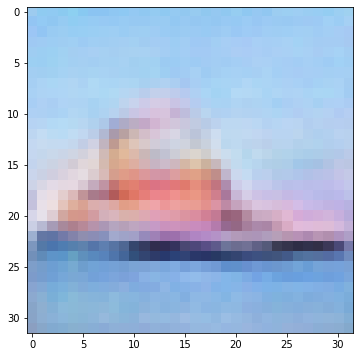

In [60]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

해당 사진 또한 바다에 떠 있는 돛단배의 모양을 보이고 있다.

에폭을 이어서 하고 싶으면 다음의 코드를 진행하면 된다.

### 2-4-3. Try#1 - 기본설정. 에폭 200번

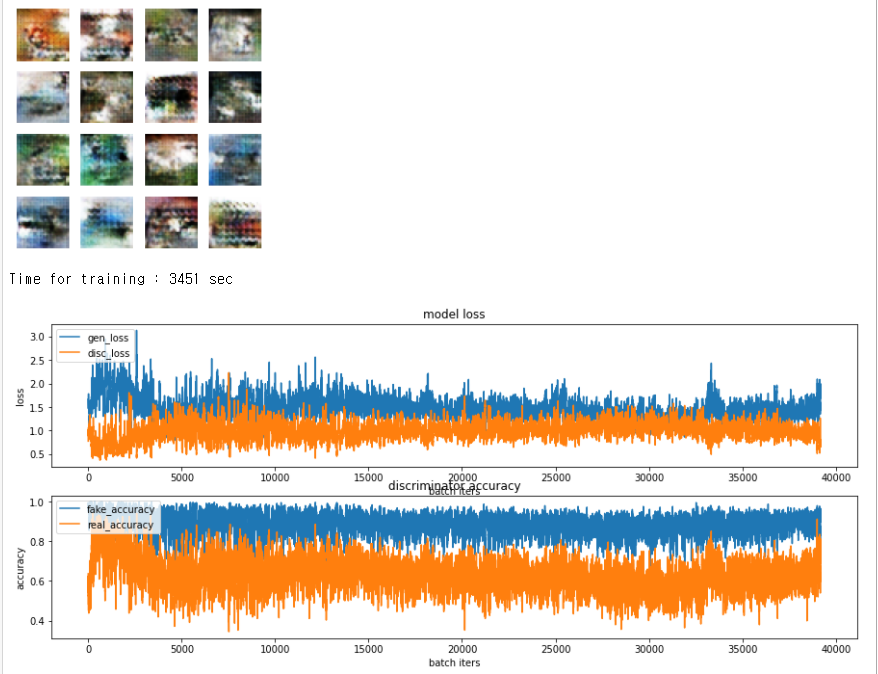

전체적으로 무난했지만, Gnerator의 loss가 너무 크고  
accuracy에서도 계속 fake Image 로 걸리고 있다.

### 2-4-4. Try#2 - Discriminator 의 최적화 함수를 SGD 로 설정했을 때

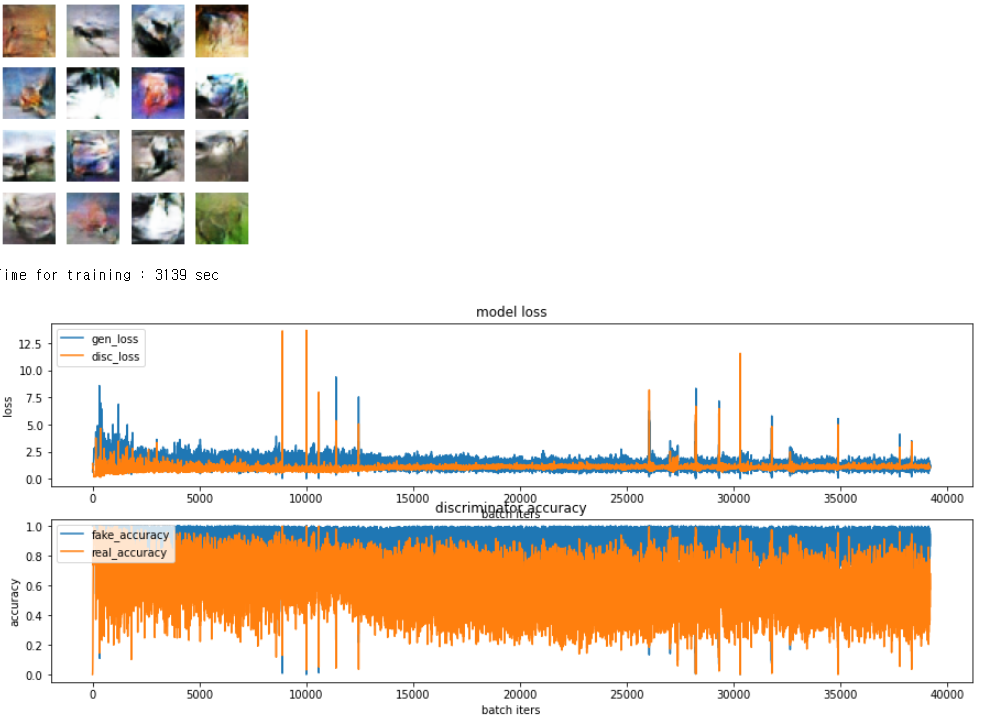

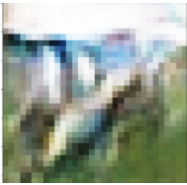
뭔가 말,, 을 만들려 한 거 같긴 한데 이게 뭔진 잘 모르겠다

두 모델의 학습과정을 면밀히 살펴보면 다음과 같다.
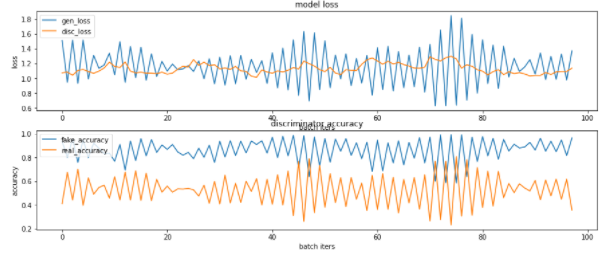


특이하게도 Discriminator 의 loss 에 따라 Generator loss 가 크게 변동하는 추세를 보인다.  
난 여기서 Generator의 learning late를 변경해주면 loss 변동폭이 감소하면서 fake Image를 더 잘 만들어 내리라는  
추측을 세워 봤다.

### 2-4-5. Try#3 Adam 의 기본값 변경
유명하신 저자의 추천에 따라  
learning late = 0.0002, beta_1 = 0.5, batch_size=128 로 변경했다.

특히 이것에 대한 결과를 에폭값의 증가율에 따라 관측했다.

**epochs 100**
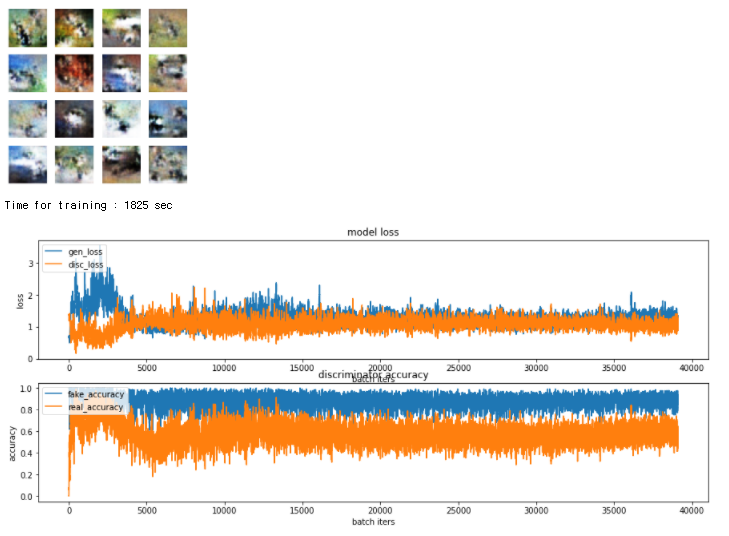

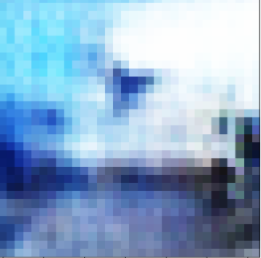

**epochs 200**

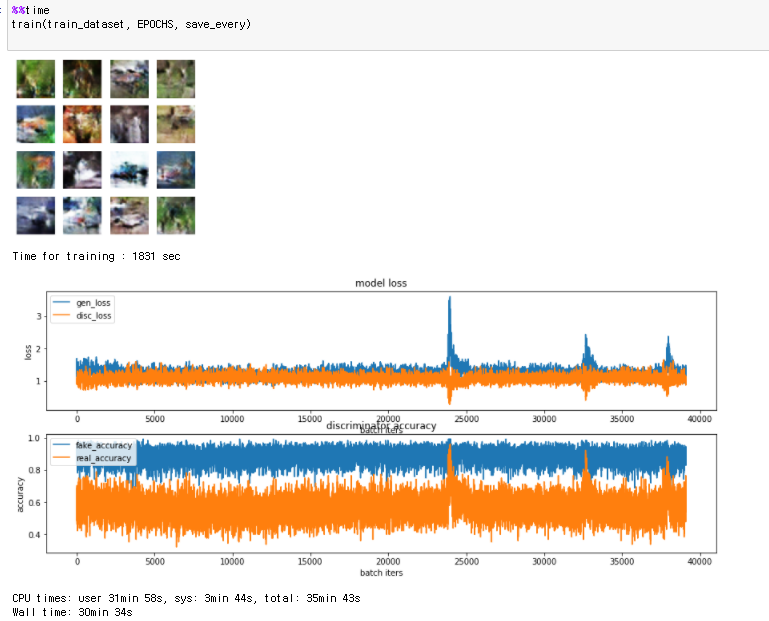

**epochs 500**

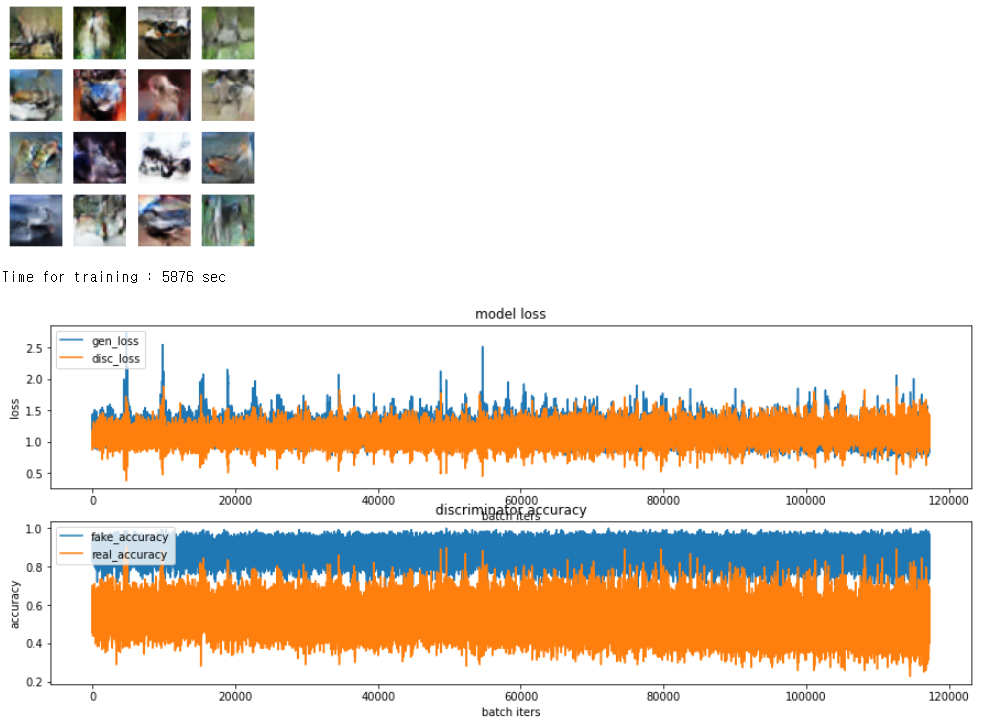

이를 통해 기존 모델보다는 Adam 값을 변경해주는게 낫다고 결론을 내렸다.
또한 epochs 값은 200 이상 500 이하가 적절할 것 같다고 판단했다


### 2-4-6. Final Try 


이를 토대로 내린 최종결정은

1. Discriminator의 최적화 함수는 SGD 르 쓰자
2. Generator의 Adam 의 파라미터를 적절하게 조절해주자
3. epochs 는 200 이상 500이하

이다.

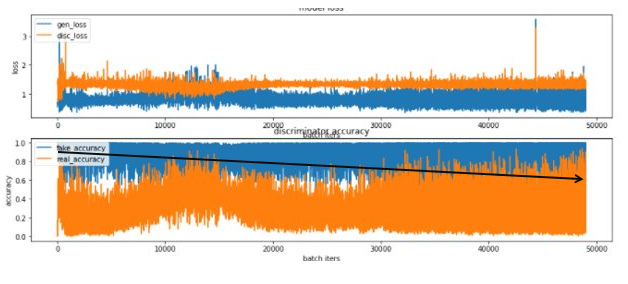

그래프가 잘 겹쳐져 보이지 않지만, 상단 최종결과에서 볼 수 있듯이  
fake acuuracy 가 빈번하게 0.5 방향으로 떨어지면서 결과적으로  
점점 떨어지는 추세선을 보이고 있다

해당 데이터를 gif 로 반환해 시각화 해보았다.

In [37]:
anim_file = os.getenv('HOME')+'/aiffel/workplace/E10/dcgan_newimage/cifar/cifar_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/workplace/E10/dcgan_newimage/cifar/generated_samples2/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/workplace/E10/dcgan_newimage/cifar/cifar_dcgan.gif

-rw-r--r-- 1 root root 3612681 Feb  9 05:44 /aiffel/aiffel/workplace/E10/dcgan_newimage/cifar/cifar_dcgan.gif


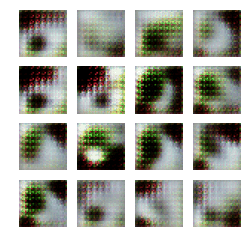

점점 이미지가 명확해지는 것을 확인 할 수 있다.

# 3. POTG
## 3-1. 소감

#### " 😡그래,, 누가 이기나 보자,, 모델을 두 개나 쓰는 커다란 학습 구성에 개선을 줄 부분이 몹시 많았습니다! "

항상 느끼지만 시각화 라이브러리를 더 쉽게 다룰 수 있었다면, 하는 아쉬움이 있습니다.  
온전히 모델에만 집중할 수 있도록 기반 실력을 다져야 합니다. 

모델 자체의 이해가 가는 프로젝트였습니다   
Generator 와 Discriminator 가 손실함수와 최적화 함수 간 상호작용한다는 부분이 신선했습니다.  

언젠가 저도 저만의 데이터를 모아 이렇게 새로운 데이터를 생성해보고 싶습니다

## 3-2. 어려웠던 점과 극복방안

### 1. 시각화 과정에서 plt 라이브러리

#### -1. Data handling 

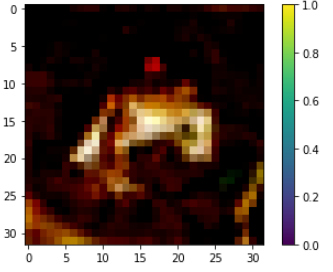

원래대로라면 -1과 1 사이에 대한 값이 나와야 한다고 생각한다.  
하지만 0에서 1값만 나왔으며, 경고문으로 0~255의 값을 넣으라고 한다.


확인 결과, Cliiping 이라는 것은 컬러로 표현하기 위해 -1 에서 0의 값을 지운 행위를 의미한다.  
때문에,  
`plt.imshow((train_x[i].reshape(32, 32, 3) +1) / 2.0) `  

로 값을 수정해주었다. 이를 통하면 -1 에서 1 사이의 값에 0을 더한 뒤 이로 나누므로,
다시 0~1사이의 값으로 변경될 것이다.

제대로 나온 사진

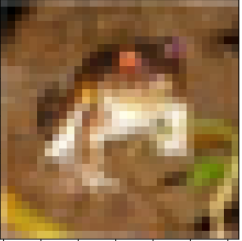

위와 달리 색이 더 풍성해짐을 알 수 있다.

#### -2. linear regression
생성된 그래프자료의 진동이 심해  
`real_accuracy` 의 추세가 내려가고 있는지 판단하기가 어려웠다.
그래서 추세선을 만드는 메서드를 추가해 비교에 용이하도록 만들었다

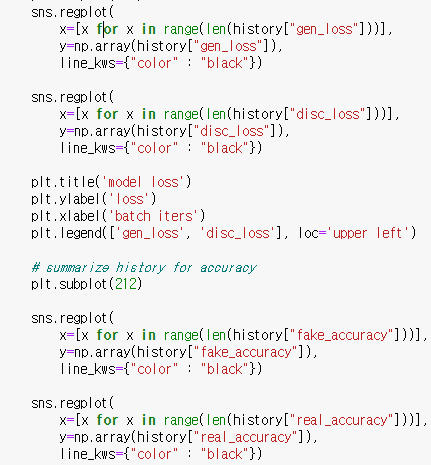

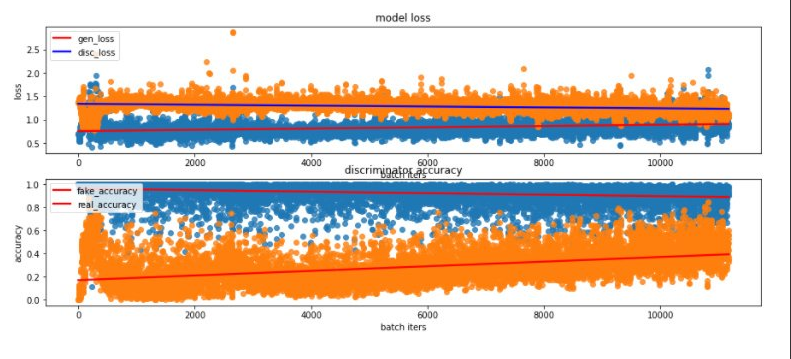



### 2. Generator 모델을 생성하는데 있어

마지막에 (32, 32, 3)의 shape 를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성하는데 어려움이 있었다.  

경우에 따라 어떤 conv2D 는 크기가 2배가 되고, 어떤 conv2D는 2배가 되지 않았기 때문이다.  

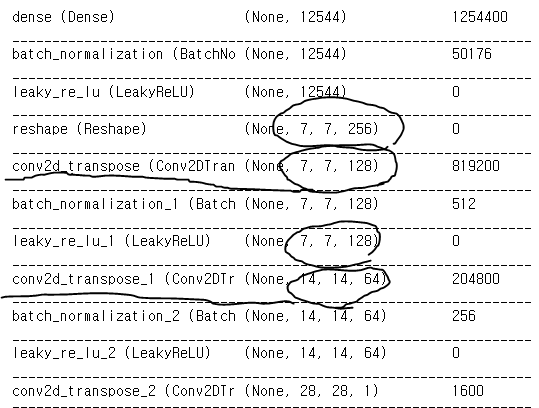

그러나 그것은 con2D transpose의 이해 부족이었다.  

Conv2DTranspose 를 사용할때, padding='same'이면 input 과 output이 동일한 사이즈가 되도록 padding값을 설정한다.  
**그러나,** stride 값이 늘어남에 따라 output 사이즈가 늘어난다는 점이 있었다.  
다시 말해서, `output size = input size * stride`    
로 쉽게 output 사이즈 계산이 가능하다.  

이 차이가 생기는 이유는 패딩 선정에 있다.  
transpose 에서 패딩을 키우게 되면 확장된 output에 모서리에는 패딩값밖에 들어가지 않는다.    
때문에 데이터 사이사이에도 패딩값을 넣어주어 데이터가 고루 퍼지도록 하는 기법을 쓴다.  

### 3. 모델 성능을 개선하는 다양한 방법이 있었다.

1. 정규화
2. 맥스풀링
3. 소프트라벨(라벨스무딩), 
4. **생성자 -ADAM, 구분자 SGD 나눠서 써보기** . 
5. 생성자에 Dropout 적용해보기. 
6. Early Stopping 바꿔주기, 
7. **Learning rate 바꿔주기, **

찾아본 자료 중에는 다음과 같이 다양한 개선 방안이 있었다.

지금까지처럼 배치사이즈나 epochs 값을 바꿔주는 것도 좋지만
무언가 모델의 헛점을 찾아내 고쳐준다는 부분이 훨씬 대단한 것 같아서  
기분이 좋았다.

비록 실력이 부족해 저 7가지 를 어떻게 적용할지 전부 터득하지는 못했다.

예를 들어,

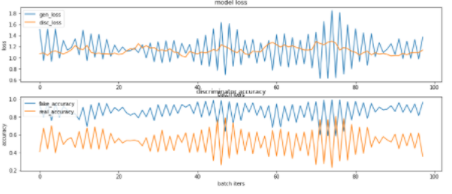

다음과 같이 loss 및 accuracy 가 무자비한 반동으로 용솟음 치는 상황에서,
Early stopping 을 위한 조건을 어떻게 주어야 할지 고민했다.

보통은 validation loss 의 값이 3번, 혹은 2번 이상 커지면 학습을 중단시키곤 하는데, 
오늘과 같은 경우는 그 변동이 지속적이었기 때문이다.

개인적으로 크롤링을 해서 여러 자료를 살펴보았는데,
learning rate 를 0.0002 로, beta_1 을 0.5 로 맞추라라는 내용이 있었다..

[GAN 사용 꿀팁](https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/)

이런 방법을 스스로 찾고 해결하면서 
문제 해결 능력이 성장했다!

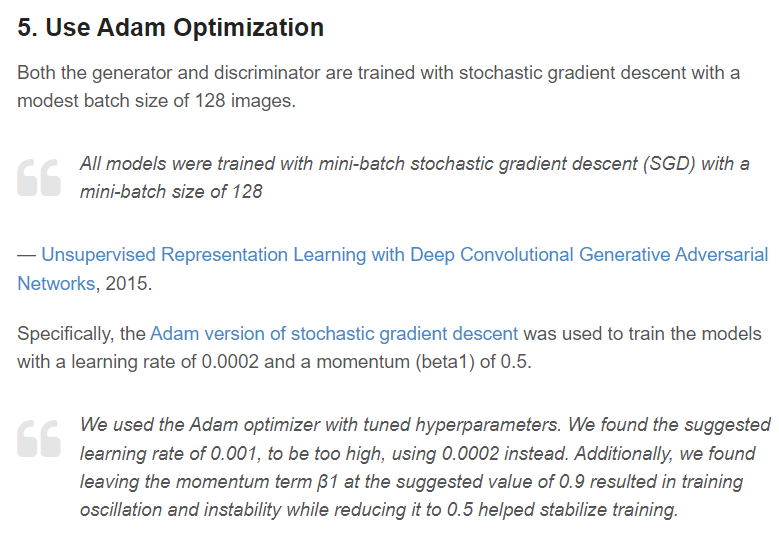


#### 이 외에

#### Dropout
Dropout 적용은 Generator 모델 생성에 사용해 보았으나 학습 도중 가중치가 죽어  
생성이미지가 새까맣게 변하는 현상이 일어났다.

#### Label_smoothing
라벨 스무딩을 시도하려 했다.

`tf.keras.losses.BinaryCrossentropy(label_smoothing=0, from_logits=True)`  
의 기본값을 0.1 로 설정하고 시도했지만 커널이 죽었다.

조사 결과, 라벨 스무딩은 여기서 하면 되는 것이 아니라  
Discriminator 의 real_accuracy 에만 적용하여 fake_acuuracy에 대한 기준을   
더 낮춰야 하는 것으로 드러났다.

하지만 어떻게 세부 항목에만 라벨 스무딩을 주는지는 알아낼 수 없었다.



## 3-3. 추후

새로운 데이터를 만들어낸다는 점이 참 매력적입니다.

저는 음악이나 글자 같은 sequence 데이터에 관심이 많아

과연 GAN 은 RNN 과 어떻게 상호작용할지가 궁금합니다.

앞으로 성실히 배워나가도록 하겠습니다